In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import numpy as np
import torchvision
from torchvision import datasets, models
from torchvision import transforms
from torchvision.models import ResNet18_Weights
from torchvision.models import ResNet50_Weights
from torchvision.models import ResNet101_Weights
from torchvision.models import ResNet152_Weights
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torch.utils.data import random_split, DataLoader
from framework.framework import FrameworkLogger
from framework.main_func import main_train_func
import os
from os import path
import datetime

In [52]:
print(torch.cuda.is_available())
print(torch.__version__)

True
2.1.0+cu121


In [53]:
input_dataset = '29_11_2023_07_24_46'

In [54]:
def dataset_path(timestamp: str):
    abs_path = os.getcwd()
    two_up =  path.abspath(path.join(abs_path ,"../.."))
    return path.join(two_up, 'data', f'{os.path.basename(abs_path)}', timestamp)

In [55]:
dataset_path(input_dataset)

'C:\\Users\\Pirmin.000\\PycharmProjects\\IGP\\data\\person_test\\29_11_2023_07_24_46'

In [56]:
transforms_wt = transforms.Compose([
    transforms.Resize(150),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

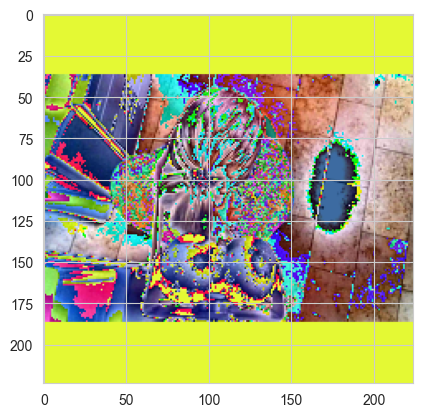

In [57]:
orig_set = datasets.ImageFolder(
    root=dataset_path(input_dataset),
    transform=transforms_wt
)
data, label = orig_set[100]
transform_test = T.ToPILImage()
plt.imshow(transform_test(data))

In [58]:
orig_set.classes

['Christina_Greiderer',
 'Christine_Lackinger',
 'Juergen_Zangerl',
 'Lukas_Prenner',
 'MartinPO_Feuerstein',
 'Martin_Hofer',
 'Philipp_Egger',
 'Pirmin_Aster',
 'Robert_Goller',
 'Suganthi_Manoharan']

In [59]:
len(orig_set)

179723

In [60]:
data, label = orig_set[0]
print(data.size())

torch.Size([3, 224, 224])


In [61]:
data_loader = DataLoader(orig_set, batch_size=len(orig_set), shuffle=True)

# Define the dataset size
dataset_size = len(orig_set)

# Calculate the sizes for training, validation, and test sets
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset into training, validation, and test sets
train_set, val_set, test_set = random_split(orig_set, [train_size, val_size, test_size])

In [62]:
val_data, val_label = val_set[1]
print(val_data.size())

torch.Size([3, 224, 224])


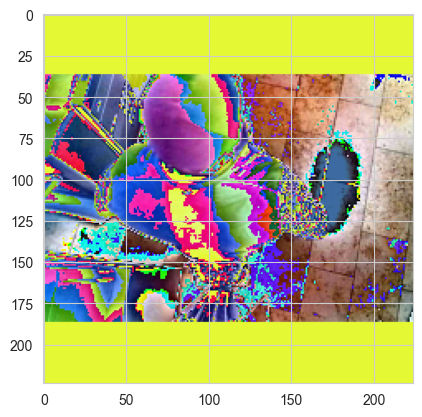

In [63]:
transform = T.ToPILImage()
plt.imshow(transform(val_data))

In [64]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=8,
    shuffle=True,
    num_workers=16
)
val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=8,
    shuffle=True,
    num_workers=16
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=8,
    shuffle=False,
    num_workers=16
)

In [65]:
model = models.resnet152(weights=ResNet152_Weights.IMAGENET1K_V2)

print(model.fc)

Linear(in_features=2048, out_features=1000, bias=True)


In [66]:
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 2048),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(2048,1024),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(1024,500),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(500,10)
)
print(model.fc)

Sequential(
  (0): Linear(in_features=2048, out_features=2048, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=2048, out_features=1024, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=1024, out_features=500, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=500, out_features=10, bias=True)
)


In [67]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

In [68]:
input_args = [train_loader, val_loader, model, criterion, optimizer, exp_lr_scheduler, device]

# Modell trainieren
logger = FrameworkLogger(5, model, main_train_func, input_args, "pirmin_person_pytorch_resnet")
logger.train_model_pyt()

Epoch 0
Epoch: 0: Train: Loss: 0.0358 Acc: 0.9111 Val: Loss: 0.0047 Acc: 0.9892
{'loss': 0.035761002839047, 'accuracy': 0.9111461639404297, 'val_loss': 0.004685192972365185, 'val_accuracy': 0.989205430669931}
Epoch 0 took 3929.41 seconds
Epoch 1
Epoch: 1: Train: Loss: 0.0096 Acc: 0.9844 Val: Loss: 0.0013 Acc: 0.9970
{'loss': 0.009566144982956267, 'accuracy': 0.9844399094581604, 'val_loss': 0.0013431001821503801, 'val_accuracy': 0.9970231471177388}
Epoch 1 took 4336.80 seconds
Epoch 2
Epoch: 2: Train: Loss: 0.0075 Acc: 0.9904 Val: Loss: 0.0034 Acc: 0.9936
{'loss': 0.007466467053988701, 'accuracy': 0.9903931617736816, 'val_loss': 0.0034074772939204335, 'val_accuracy': 0.9935733363009126}
Epoch 2 took 4441.74 seconds
Epoch 3
Epoch: 3: Train: Loss: 0.0067 Acc: 0.9917 Val: Loss: 0.0020 Acc: 0.9975
{'loss': 0.006717941200811026, 'accuracy': 0.9916821122169495, 'val_loss': 0.0020016127988409763, 'val_accuracy': 0.997523926107278}
Epoch 3 took 4549.94 seconds
Epoch 4
Epoch: 4: Train: Loss: 0.0

In [77]:
#logger.generate_statistics()

In [69]:
def get_time():
    return datetime.datetime.now().strftime("%d_%m_%Y_%H_%M_%S")

In [70]:
def model_save_path(timestamp: str):
    abs_path = os.getcwd()
    two_up =  path.abspath(path.join(abs_path ,"../.."))
    return path.join(two_up, 'models', f'{os.path.basename(abs_path)}', timestamp, f'model_{get_time()}.pt')

In [71]:
model_save_path(input_dataset)

'C:\\Users\\Pirmin.000\\PycharmProjects\\IGP\\models\\person_test\\29_11_2023_07_24_46\\model_29_11_2023_17_31_06.pt'

In [72]:
save_path = model_save_path(input_dataset)

os.makedirs(os.path.dirname(save_path), exist_ok=True)

torch.save(model.state_dict(), save_path)

In [73]:
num_correct = 0.0
for inputs, labels in test_loader:
    model.eval()
    inputs = inputs.to(device)
    labels = labels.to(device)
    predict_label = model(inputs)
    _, predicted = torch.max(predict_label,1)
    num_correct += (predicted == labels).float().sum()

    accuracy = num_correct/(len(test_loader)*test_loader.batch_size)

print(len(test_loader), test_loader.batch_size)
print("Test Accuracy: {}".format(accuracy))

4494 8
Test Accuracy: 0.9952158331871033


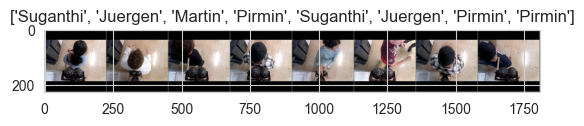

In [75]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.show()

def print_grid():
    inputs, classes = next(iter(test_loader))
    out = torchvision.utils.make_grid(inputs)
    class_names = orig_set.classes

    outputs = model(inputs.to(device))
    _, preds = torch.max(outputs, 1)

    imshow(out, title=[class_names[x].split('_')[0] for x in preds])

print_grid()